In [15]:
# default_exp protein_ptm_normalization

In [16]:
#hide
%reload_ext autoreload
%autoreload 2

## Module Tests

In [17]:
#hide
import alphaquant.ptm.protein_ptm_normalization as aqptmnorm

def test_fdr_damping():
    check_that_half_fc_is_half_logfdr()
    check_that_half_fc_is_half_logfdr_minus()
    check_that_unsignificant_protein_retains_ptm_fdr()
    check_that_no_protfc_is_ptmfdr()
    check_that_same_fc_equals_fdr1()


def check_that_half_fc_is_half_logfdr():
    reginfos = aqptmnorm.RegulationInfos(log2fc_ptm=1.5, fdr_ptm=1e-10, log2fc_protein=0.75,fdr_protein=0.001)
    fdrdamper = aqptmnorm.FDRDamper(reginfos)
    damped_fdr = fdrdamper.get_fdr()
    assert damped_fdr == 1e-5

def check_that_half_fc_is_half_logfdr_minus():
    reginfos = aqptmnorm.RegulationInfos(log2fc_ptm=-1.5, fdr_ptm=1e-10, log2fc_protein=-0.75,fdr_protein=0.001)
    fdrdamper = aqptmnorm.FDRDamper(reginfos)
    damped_fdr = fdrdamper.get_fdr()
    assert damped_fdr == 1e-5

def check_that_unsignificant_protein_retains_ptm_fdr():
    reginfos = aqptmnorm.RegulationInfos(log2fc_ptm=1.5, fdr_ptm=1e-10, log2fc_protein=0.75,fdr_protein=0.1)
    fdrdamper = aqptmnorm.FDRDamper(reginfos)
    damped_fdr = fdrdamper.get_fdr()
    assert damped_fdr == 1e-10

def check_that_no_protfc_is_ptmfdr():
    reginfos =aqptmnorm.RegulationInfos(log2fc_ptm=1.5, fdr_ptm=1e-10, log2fc_protein=0,fdr_protein=0.001)
    fdrdamper = aqptmnorm.FDRDamper(reginfos)
    damped_fdr = fdrdamper.get_fdr()
    assert damped_fdr == 1e-10

def check_that_same_fc_equals_fdr1():
    reginfos = aqptmnorm.RegulationInfos(log2fc_ptm=1.5, fdr_ptm=1e-10, log2fc_protein=1.5,fdr_protein=0.001)
    fdrdamper = aqptmnorm.FDRDamper(reginfos)
    damped_fdr = fdrdamper.get_fdr()
    assert damped_fdr == 1

test_fdr_damping()

### Simulate Results outputs

In [18]:
#hide
import pandas as pd
import os
import shutil
import random
import numpy as np
import glob


RESULTS_DIR_SIMULATED_PROTEOME = "../test_data/unit_tests/protein_ptm_normalization/toy_data/results_proteome"
RESULTS_DIR_SIMULATED_PTM = "../test_data/unit_tests/protein_ptm_normalization/toy_data/results_ptm"

class ResultsDirSimulator():
    def __init__(self, results_dir_protein, results_dir_ptm, resultswriterconfig_vec):
        self._results_dir_protein = results_dir_protein
        self._results_dir_ptm = results_dir_ptm
        self._resultswriterconfig_vec = resultswriterconfig_vec
        self._create_toy_results_dirs()
        self._write_out_simulated_dataframes()

    
    def _create_toy_results_dirs(self):
        self._create_or_replace_folder(self._results_dir_protein)
        self._create_or_replace_folder(self._results_dir_ptm)
    
    @staticmethod
    def _create_or_replace_folder(folder):
        if os.path.exists(folder):
            shutil.rmtree(folder)
        os.makedirs(folder)

    def _write_out_simulated_dataframes(self):
        for idx, resultswriterconfig in enumerate(self._resultswriterconfig_vec):
            condpairname = f"condpair{idx}" #make up a name for the tables
            resultswriterconfig.filenames_w_config.append(condpairname)
            resutstable_simulator = ResultsTableSimulator(resultswriterconfig)
            self._save_dataframe(resutstable_simulator.protein_df, self._results_dir_protein, condpairname)
            self._save_dataframe(resutstable_simulator.ptm_df, self._results_dir_ptm, condpairname)

    @staticmethod
    def _save_dataframe(df, results_dir, name):
        df.to_csv(f"{results_dir}/{name}.results.tsv", sep = "\t", index = None)


class ResultsTableSimulator():
    def __init__(self, resultswriterconfig):
        self.protein_df = None
        self.ptm_df = None
        self._resultswriterconfig = resultswriterconfig
        self._simulate_dataframes_as_specified()
    
    def _simulate_dataframes_as_specified(self):
        protein_df_initial = self._simulate_protein_df()
        ptm_df_initial = self._simulate_ptm_df(protein_df_initial, offset_fc_to_protein=self._resultswriterconfig.offset_fc)
        self.protein_df =self._remove_rows_from_df(protein_df_initial, nrows_to_remove=self._resultswriterconfig.number_missing_proteins)
        self.ptm_df = self._remove_rows_from_df(ptm_df_initial, nrows_to_remove=self._resultswriterconfig.number_missing_ptms)

    def _simulate_protein_df(self):
        proteins = [f'name{x}' for x in range(self._resultswriterconfig.length)]
        fcs = self._get_fcs()
        np.random.seed(42)
        fdr = [10**(-np.random.uniform(0, 10)) for x in range(self._resultswriterconfig.length)]
        return pd.DataFrame(data = {'protein' : proteins, 'log2fc' : fcs, 'fdr' : fdr})

    def _get_fcs(self):
        np.random.seed(42)
        if self._resultswriterconfig.fc_for_all_proteins is not None:
            return [self._resultswriterconfig.fc_for_all_proteins for x in range( self._resultswriterconfig.length)]
        else:
            return [np.random.uniform(low = -2, high= 2) for x in range(self._resultswriterconfig.length)]
    
    @staticmethod
    def _simulate_ptm_df(protein_df, offset_fc_to_protein):
        ptm_df = protein_df.copy()
        ptm_df["swissprot"] = protein_df["protein"]
        ptm_df["protein"] = [f"genename_{x}_ptmsite" for x in protein_df["protein"]]
        ptm_df["log2fc"] = [x + offset_fc_to_protein for x in ptm_df["log2fc"]]
        return ptm_df
    
    @staticmethod
    def _remove_rows_from_df(results_df, nrows_to_remove):
        all_idxs = list(results_df.index)
        randomly_sampled_idxs_to_remove = random.sample(all_idxs, nrows_to_remove)
        return results_df.drop(index = randomly_sampled_idxs_to_remove)


class ResultsWriterConfig():
    def __init__(self, length, offset_fc, number_missing_proteins, number_missing_ptms, fc_for_all_proteins = None):
        self.length = length
        self.offset_fc = offset_fc
        self.number_missing_proteins = number_missing_proteins
        self.number_missing_ptms = number_missing_ptms
        self.filenames_w_config = []
        self.fc_for_all_proteins = fc_for_all_proteins




### Check that normalized outputs are as expected from simulation

In [22]:
import itertools

class PTMNormalizationTester():
    def __init__(self, simulate_new = True):
        self._results_config_vec = self._create_results_config_vec()
        self._filename2results_config = {}
        self._results_ptm = RESULTS_DIR_SIMULATED_PTM
        self._results_proteome = RESULTS_DIR_SIMULATED_PROTEOME
        self._simulate_results_dir(simulate_new)
        self._localizer = self._get_ptmtable_localizer()

    def _create_results_config_vec(self):
        config1 = ResultsWriterConfig(50, 1, 8, 9)
        config2 = ResultsWriterConfig(50, -0.5, 8, 9)
        config3 = ResultsWriterConfig(50, +1.5, 38, 38)
        config4 = ResultsWriterConfig(50, 1.5,0, 0, 0.5)
        
        results_config_vec = [config1 for _ in range(10)] + [config2 for _ in range(10)] + [config3 for _ in range(10)] + [config4 for _ in range(2)]
        return results_config_vec

    def _simulate_results_dir(self, simulate_new):
        if simulate_new:
            ResultsDirSimulator(self._results_proteome, self._results_ptm, self._results_config_vec)

    def _get_ptmtable_localizer(self):
        return aqptmnorm.PTMtableLocalizer(self._results_ptm, self._results_proteome)

    def test_correct_localization(self):
        ptmfile2name = self._localizer.get_ptmfile2name()
        assert len(ptmfile2name) == len(self._results_config_vec)
        list_of_filelists = [x.filenames_w_config for x in self._results_config_vec]
        all_files = list(set(itertools.chain.from_iterable(list_of_filelists)))
        assert sorted(all_files) == sorted(list(ptmfile2name.values()))

    def test_correct_normalization(self):
        ptmnorm = aqptmnorm.PTMResultsNormalizer(self._results_ptm, self._results_proteome)
        ptmnorm.write_normalized_tables()
        self._check_that_fcs_are_as_expected(ptmnorm.results_dir_protnormed)
        

    def _check_that_fcs_are_as_expected(self, results_dir_protnormed):
        all_files = glob.glob(f"{results_dir_protnormed}/*")
        for file in all_files:
            df = pd.read_csv(file, sep = "\t")
            assert self._fcs_match_resultsconfig(list(df['log2fc']))

    def _fcs_match_resultsconfig(self, log2fcs_list):
        for resconf in set(self._results_config_vec):
            comparevec = [resconf.offset_fc for x in log2fcs_list]
            if np.allclose(log2fcs_list, comparevec):
                return True
        return False


simulate_new = True
ptmnormtester = PTMNormalizationTester(simulate_new=simulate_new) 
if simulate_new:
    ptmnormtester.test_correct_localization()
ptmnormtester.test_correct_normalization()


### Visualize PTMs

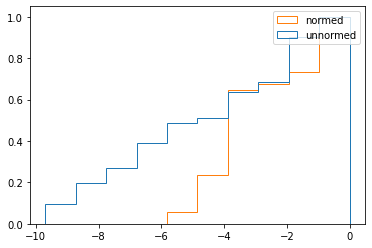

In [23]:
import alphaquant.viz.visualizations as aqplot
import matplotlib.pyplot as plt


results_df_ptm = pd.read_csv("../test_data/unit_tests/protein_ptm_normalization/toy_data/results_ptm/condpair0.results.tsv", sep = "\t")
results_df_protnormed = pd.read_csv("../test_data/unit_tests/protein_ptm_normalization/toy_data/results_ptm_protnormed/condpair0.results.tsv", sep = "\t")

histogram_input = [np.log10(results_df_ptm["fdr"]), np.log10(results_df_protnormed["fdr"])]
labels = ["unnormed", "normed"]
plt.hist(histogram_input, cumulative=True, histtype='step', label=labels, density=True)
plt.legend()


assert min(histogram_input[0])<=min(histogram_input[1])

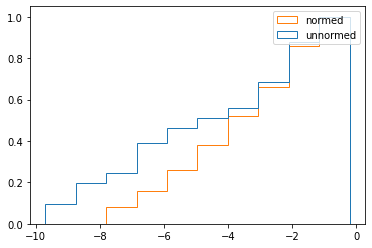

In [24]:
import matplotlib.pyplot as plt


results_df_ptm_nochange = pd.read_csv("../test_data/unit_tests/protein_ptm_normalization/toy_data/results_ptm/condpair31.results.tsv", sep = "\t")
results_df_protnormed = pd.read_csv("../test_data/unit_tests/protein_ptm_normalization/toy_data/results_ptm_protnormed/condpair31.results.tsv", sep = "\t")

histogram_input = [np.log10(results_df_ptm["fdr"]), np.log10(results_df_protnormed["fdr"])]
labels = ["unnormed", "normed"]
plt.hist(histogram_input, cumulative=True, histtype='step', label=labels, density=True)
plt.legend()



assert min(histogram_input[0])<=min(histogram_input[1])